# REINFORCE with Gaussian Policy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(['science', 'retro', 'grid'])
import gym

We implement a Gaussian policy with the following updates


$$\theta_{\mu, t+1} = \theta_{\mu, t} + \alpha G_t x_{\mu}(s) \frac{(a - \theta_{\mu}^{T} x_{\mu}(s))}{\exp{\left(2\theta_{\sigma}^{T} x_{\sigma}(s)\right)}}$$

$$\theta_{\sigma, t+1} = \theta_{\sigma, t} + \alpha G_t x_{\sigma}(s)\left( \frac{(a - \theta_{\mu}^{T} x_{\mu}(s))^2}{\exp{\left(2\theta_{\sigma}^{T} x_{\sigma}(s)\right)}} - 1 \right)$$

In [54]:
class GaussianPolicyLearnableVar:
    
    def __init__(self, feat_dim, α_μ=0.0001,  α_σ=0.0001, γ=0.9):
        self.θ_μ = np.random.rand(feat_dim)
        self.θ_σ = np.random.rand(feat_dim)
        self.α_μ = α_μ
        self.α_σ = α_σ
        self.γ = γ
        
    def act(self, s):
        μ = self.θ_μ @ s
        σ = np.exp(self.θ_σ @ s)
        
        a = np.random.normal(μ, σ)
        return a
    
    def μ_grad(self, state, action):
        μ = self.θ_μ @ state
        σ = np.exp(self.θ_σ @ state)

        return (1/σ**2)*(action - μ)*state
    
    def σ_grad(self, state, action):
        μ = self.θ_μ @ state
        σ = np.exp(self.θ_σ @ state)

        return ((((action - μ)**2)/(σ**2)) - 1)*state
    
    # Agent uses sample returns for evaluating policy
    def discount_rewards(self, rewards):
        discounted_rewards = np.zeros_like(rewards)
        running_add = 0
        for t in reversed(range(0, len(rewards))):
            running_add = running_add * self.γ + rewards[t]
            discounted_rewards[t] = running_add
        return discounted_rewards

    
    def update(self, states, actions, rewards):
        
        μ_grads = []
        σ_grads = []
        for  s, a in zip(states, actions):
            μ_grads.append(self.μ_grad(s, a))
            σ_grads.append(self.σ_grad(s, a))
            
        G = self.discount_rewards(rewards)
        
        for μg, σg, Gt in zip(μ_grads, σ_grads, G):
            self.θ_μ += self.α_μ*Gt*μg
            self.θ_σ += self.α_σ*Gt*σg

#### The following policy is the same as above but with a constant standard deviation

In [41]:
class GaussianPolicyControlledVar:
    
    def __init__(self, feat_dim, σ=1, α=0.0001, γ=0.9):
        self.θ_μ = np.random.rand(feat_dim)
        self.σ = 1
        self.α = α
        self.γ = γ
        
    def act(self, s):
        μ = self.θ_μ @ s

        a = np.random.normal(μ, 1)
        return a
    
    def μ_grad(self, state, action):
        μ = self.θ_μ @ state

        return (1/self.σ**2)*(action - μ)*state
    
    def discount_rewards(self, rewards):
        discounted_rewards = np.zeros_like(rewards)
        running_add = 0
        for t in reversed(range(0, len(rewards))):
            running_add = running_add * self.γ + rewards[t]
            discounted_rewards[t] = running_add
        return discounted_rewards

    
    def update(self, states, actions, rewards):
        μ_grads = []
        for  s, a in zip(states, actions):
            μ_grads.append(self.μ_grad(s, a))

            
        G = self.discount_rewards(rewards)  
        for μg, Gt in zip(μ_grads, G):
            self.θ_μ += self.α*Gt*μg


In [5]:
def generate_episode(env, policy):
    state = env.reset()
    
    tot_reward = 0
    states = []
    actions = []
    rewards = []
    probs = []
    
    done = False
    
    while not done:
        
        states.append(state)
        
        action = policy.act(state)
        state, reward, done, _ = env.step([action])
       
        
        tot_reward += reward
        rewards.append(reward)
        actions.append(action)
    
    return np.array(states), np.array(actions), np.array(rewards), tot_reward

In [55]:
def train(α_μ, α_σ, γ, num_episodes=1000, seed=None, evaluate=False):
    
    env = gym.make('MountainCarContinuous-v0')
    if seed is not None:
        env.seed(seed)
    episode_rewards = []
    policy = GaussianPolicyLearnableVar(2, α_μ=α_μ, α_σ=α_σ, γ=γ)
    
    for i in range(num_episodes):

        # run a single episode
        states, actions, rewards, total_reward = generate_episode(env, policy)
                
        # keep track of episode rewards
        episode_rewards.append(total_reward)
        
        # update policy
        policy.update(states, actions, rewards)
        print("EP: " + str(i) + " Score: " + str(total_reward) + " ",end="\r", flush=False) 

    return episode_rewards, policy

In [68]:
episode_rewards, policy = train(α_μ=0.01,
                                α_σ=1e-6,
                                γ=0.9,
                                num_episodes=2000,
                                evaluate=True)

In [69]:
policy.θ_σ

array([0.31547455, 0.21714365])

In [70]:
policy.θ_μ

array([-0.56508588, 21.33098882])

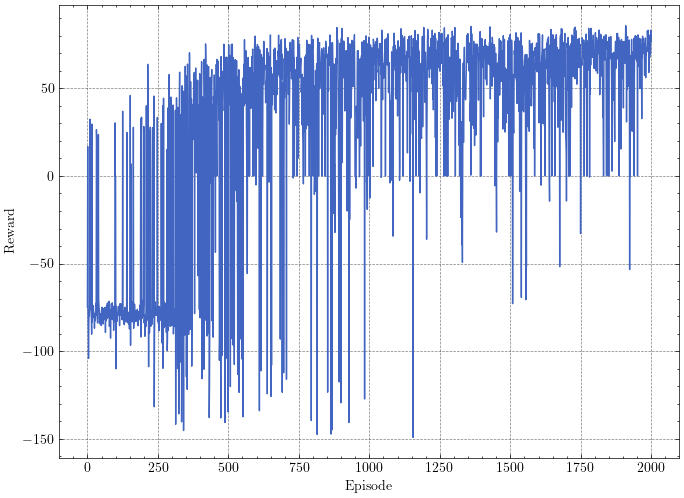

In [71]:
data = np.array(episode_rewards) 
data[data < -150] = 0
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(np.arange(2000), data)
plt.xlabel('Episode')
plt.ylabel('Reward');

In [4]:
def train(α, γ, num_episodes=1000, seed=None, evaluate=False):
    
    env = gym.make('MountainCarContinuous-v0')
    if seed is not None:
        env.seed(seed)
    episode_rewards = []
    policy = GaussianPolicyControlledVar(2, σ=1, α=α, γ=γ)
    
    for i in range(num_episodes):

        # run a single episode
        states, actions, rewards, total_reward = generate_episode(env, policy)
                
        # keep track of episode rewards
        episode_rewards.append(total_reward)
        
        # update policy
        policy.update(states, actions, rewards)
        print("EP: " + str(i) + " Score: " + str(total_reward) + " ",end="\r", flush=False) 

    return episode_rewards, policy

In [44]:
episode_rewards, policy = train(α=0.01,
                                γ=0.9,
                                num_episodes=2000,
                                evaluate=True)

In [46]:
data = np.array(episode_rewards) 
data[data < -150] = 0

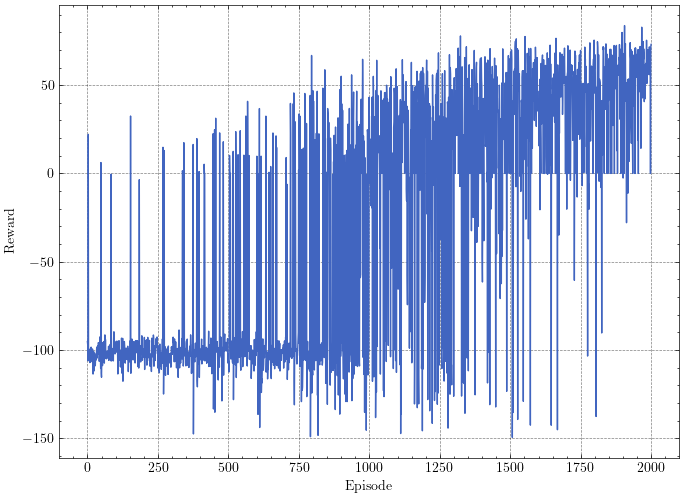

In [66]:
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(np.arange(2000), data)
plt.xlabel('Episode')
plt.ylabel('Reward');

In [63]:
smooth = np.array(pd.Series(episode_rewards).rolling(15).mean()[10 - 1:])

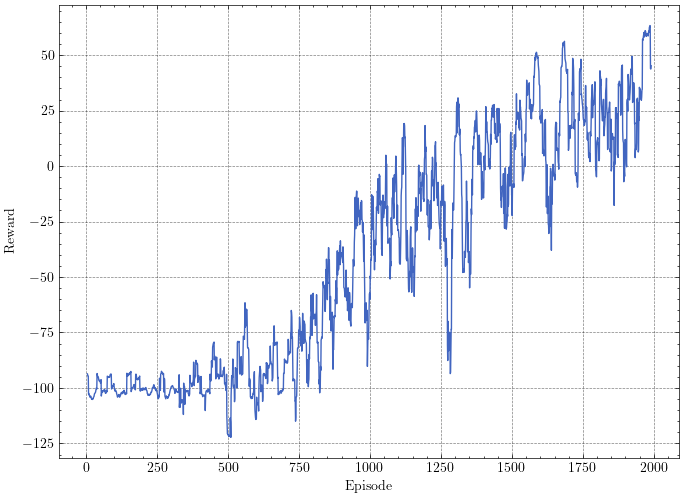

In [67]:
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(np.arange(1991), smooth)
plt.xlabel('Episode')
plt.ylabel('Reward');